In [91]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [92]:
import numpy as np
import tensorflow as tf
from keras.datasets import cifar10
(features, labels), (X_test_orig, Y_test_orig) = cifar10.load_data()
features = features/255 - 0.5
labels = labels.flatten()

test_images = X_test_orig/255 - 0.5
test_labels = Y_test_orig.flatten()


In [93]:
#for stability
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

reset_graph()

In [94]:
print('designing model')
# Training Parameters
learning_rate = 0.005
n_epochs = 2500 # changed to 2500 for a LB score of ~2.69


# Network Parameters
num_input = 32*32 #size of the images
num_classes = 10 # Binary
dropout = 0.4 # Dropout, probability to keep units

designing model


In [95]:
X = tf.placeholder(tf.float32, shape=(None, 32, 32, 3), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")


with tf.variable_scope('ConvNet'):
    # Convolutional Layer #1
    dropout_rate = 0.3

    training = tf.placeholder_with_default(False, shape=(), name='training')
    X_drop = tf.layers.dropout(X, dropout_rate, training=training)
    conv1 = tf.layers.conv2d(X_drop, filters=32,
                         kernel_size=5,
                         strides=1, padding="SAME",
                         activation=tf.nn.relu, name="conv1")

    conv2 = tf.layers.conv2d(conv1, filters=64, 
                         kernel_size=3,
                         strides=2, padding="SAME",
                         activation=tf.nn.relu, name="conv2")
    pool3 = tf.nn.max_pool(conv2,
                       ksize=[1, 2, 2, 1],
                       strides=[1, 2, 2, 1],
                       padding="VALID")
    conv4 = tf.layers.conv2d(pool3, filters=128, 
                         kernel_size=4,
                         strides=3, padding="SAME",
                         activation=tf.nn.relu, name="conv4")

    pool5 = tf.nn.max_pool(conv4,
                       ksize=[1, 2, 2, 1],
                       strides=[1, 1, 1, 1],
                       padding="VALID")

    pool5_flat = tf.contrib.layers.flatten(pool5)

    fullyconn1 = tf.layers.dense(pool5_flat, 128,
                             activation=tf.nn.relu, name="fc1")

    fullyconn2 = tf.layers.dense(fullyconn1, 64,
                             activation=tf.nn.relu, name="fc2")
    logits = tf.layers.dense(fullyconn2, 10, name="output")

In [96]:
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [97]:
with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

In [98]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [99]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [100]:
def get_next_batch(features, labels, train_size, batch_index, batch_size):
    training_images = features[:train_size,:,:]
    training_labels = labels[:train_size]
    
    start_index = batch_index * batch_size
    end_index = start_index + batch_size

    return features[start_index:end_index,:,:], labels[start_index:end_index]

In [90]:
print('training model\n')
n_epochs = 50
batch_size = 128

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
#         batch_index = 0
        # Add this in when we want to run the training on all batches in CIFAR-10
        batch_index = 0

        train_size = int(len(features))

        for iteration in range(train_size // batch_size):
            X_batch, y_batch = get_next_batch(features, 
                                                                        labels, 
                                                                        train_size, 
                                                                        batch_index,
                                                                        batch_size)
            batch_index += 1

            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: test_images, y: test_labels})
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)
        print ("Train Accuracy:", round(acc_train, 2)*100,"%",  end="\t")
        print ("Test Accuracy:", round(acc_test, 2)*100,"%", end="\n")
    #    save_path = saver.save(sess, "./cifar_model")
    save_path = saver.save(sess, "./cam_iceberg_model_final.ckpt")

training model

0 Train accuracy: 0.59375 Test accuracy: 0.5229
Train Accuracy: 58.9999973774 %	Test Accuracy: 51.9999980927 %
1 Train accuracy: 0.6875 Test accuracy: 0.6043
Train Accuracy: 68.9999997616 %	Test Accuracy: 60.0000023842 %
2 Train accuracy: 0.71875 Test accuracy: 0.6397
Train Accuracy: 72.000002861 %	Test Accuracy: 63.9999985695 %
3 Train accuracy: 0.78125 Test accuracy: 0.6484
Train Accuracy: 77.999997139 %	Test Accuracy: 64.9999976158 %
4 Train accuracy: 0.835938 Test accuracy: 0.6732
Train Accuracy: 83.9999973774 %	Test Accuracy: 67.0000016689 %
5 Train accuracy: 0.835938 Test accuracy: 0.6803
Train Accuracy: 83.9999973774 %	Test Accuracy: 68.0000007153 %
6 Train accuracy: 0.851562 Test accuracy: 0.6791
Train Accuracy: 85.0000023842 %	Test Accuracy: 68.0000007153 %
7 Train accuracy: 0.914062 Test accuracy: 0.6793
Train Accuracy: 91.0000026226 %	Test Accuracy: 68.0000007153 %
8 Train accuracy: 0.835938 Test accuracy: 0.6532
Train Accuracy: 83.9999973774 %	Test Accuracy:

In [122]:

print('making predictions\n')
#make external predictions on the test_dat
with tf.Session() as sess:
    saver.restore(sess, "./cam_iceberg_model_final.ckpt") # or better, use save_path
    import cv2
    img = cv2.imread("horse1.png")
    img = cv2.resize(img, (32, 32))
    resized_image_flatten = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
    classnames = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    print("Your algorithm predicts: y = " + classnames[logits.eval(feed_dict={X: resized_image_flatten}).argmax()])




making predictions

INFO:tensorflow:Restoring parameters from ./cam_iceberg_model_final.ckpt


INFO:tensorflow:Restoring parameters from ./cam_iceberg_model_final.ckpt


(32, 32, 3)
(1, 32, 32, 3)
3
Your algorithm predicts: y = cat


making predictions

INFO:tensorflow:Restoring parameters from ./cam_iceberg_model_final.ckpt


INFO:tensorflow:Restoring parameters from ./cam_iceberg_model_final.ckpt


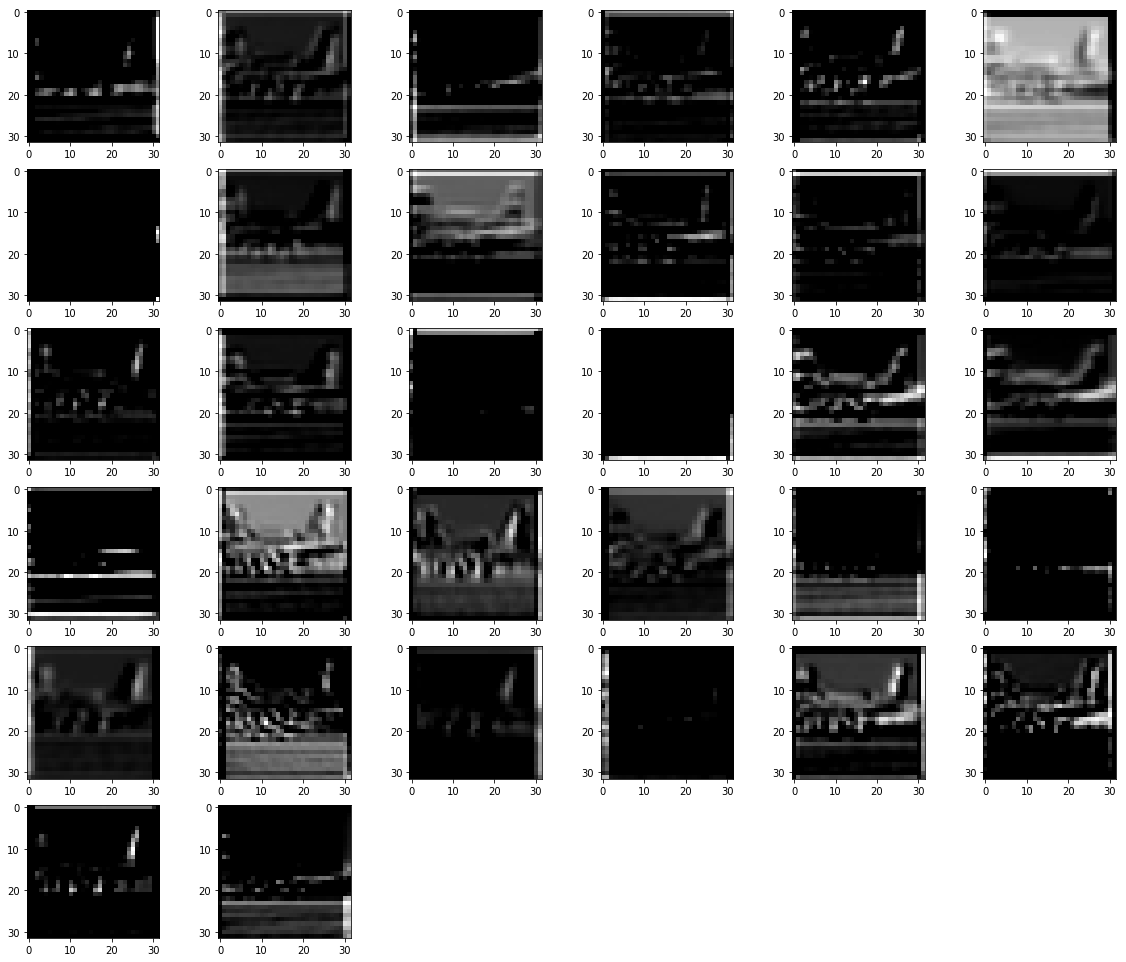

In [138]:
import matplotlib as mp
%matplotlib inline
import matplotlib.pyplot as plt
import math
import tensorflow as tf
print('making predictions\n')
#make external predictions on the test_dat
with tf.Session() as sess:
    saver.restore(sess, "./cam_iceberg_model_final.ckpt") # or better, use save_path
    import cv2
    img = cv2.imread("airplane1.png")
    img = cv2.resize(img, (32, 32))
    resized_image_flatten = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
    classnames = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    units = conv1.eval(feed_dict={X: resized_image_flatten})
    filters = units.shape[3]
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")


In [105]:
for a, b in zip(Z, test_labels):
    print(a.argmax(), b)

5 3
8 8
0 8
8 0
6 6
7 6
9 1
6 6
3 3
1 1
0 0
9 9
5 5
7 7
9 9
8 8
3 5
7 7
8 8
6 6
7 7
0 0
4 4
9 9
4 5
2 2
3 4
0 0
9 9
6 6
6 6
4 5
2 4
5 5
9 9
1 2
4 4
0 1
9 9
5 5
4 4
6 6
7 5
6 6
0 0
9 9
3 3
9 9
7 7
2 6
9 9
8 8
6 0
3 3
8 8
0 8
7 7
5 7
4 4
3 6
7 7
5 3
4 6
9 3
6 6
2 2
1 1
2 2
7 3
1 7
0 2
6 6
8 8
8 8
9 0
2 2
0 9
5 3
3 3
8 8
8 8
1 1
1 1
7 7
7 2
7 5
7 2
8 7
8 8
9 9
0 0
6 3
8 8
6 6
4 4
6 6
6 6
0 0
0 0
7 7
7 4
9 5
6 6
3 3
1 1
1 1
3 3
6 6
3 8
7 7
4 4
0 0
2 6
2 2
1 1
7 3
0 0
2 4
6 2
5 7
8 8
7 3
1 1
7 2
8 8
2 0
8 8
3 3
3 5
0 2
2 4
1 1
8 8
9 9
1 1
2 2
9 9
7 7
2 2
0 9
6 6
5 5
6 6
3 3
8 8
0 7
6 6
5 2
5 5
2 2
0 8
9 9
6 6
9 0
0 0
5 5
2 2
9 9
3 5
4 4
0 2
1 1
3 6
6 6
0 8
0 4
8 8
6 4
7 5
0 0
9 9
0 9
9 9
8 8
9 9
9 9
5 3
7 7
5 5
0 0
0 0
5 5
2 2
6 2
5 3
8 8
6 6
3 3
3 4
8 0
2 5
8 8
4 0
1 1
7 7
2 2
8 8
9 8
5 7
3 8
3 5
1 1
8 8
7 7
1 1
3 3
8 0
5 5
7 7
9 9
5 7
0 4
5 5
9 9
8 8
0 0
7 7
9 9
0 8
2 2
7 7
6 6
9 9
7 4
9 3
9 9
6 6
2 4
9 7
6 6
3 5
1 1
7 5
0 8
8 8
0 0
4 4
7 0
6 5
3 5
1 1
9 1
1 8
9 9
0 0
8 3
1 1
4 9
2 2
3 2


3 5
3 3
5 4
0 0
8 0
1 9
1 1
0 0
3 2
1 5
9 9
7 7
8 8
6 6
8 4
6 6
0 0
2 2
8 0
1 1
9 9
4 2
4 4
9 9
2 0
4 7
2 2
3 3
5 4
8 8
9 0
3 2
6 6
8 8
9 9
7 7
1 1
9 9
3 3
7 7
2 2
7 7
9 9
6 6
9 9
5 5
7 7
8 8
5 5
9 9
8 8
4 3
9 9
7 8
0 0
5 5
8 5
7 7
1 1
0 2
0 0
6 7
5 5
8 8
2 2
5 2
4 5
0 3
1 9
7 3
1 1
9 9
3 3
1 1
4 4
6 3
4 4
4 4
9 9
9 0
1 9
6 5
9 9
2 2
9 9
5 4
2 0
8 2
8 8
6 4
8 8
6 6
8 8
4 2
0 0
7 5
9 9
6 6
9 9
5 5
1 1
6 3
4 4
4 4
2 2
7 7
2 2
6 4
5 4
9 0
7 2
8 8
4 4
3 5
1 1
2 2
4 6
8 8
1 1
7 7
6 2
8 8
7 7
4 4
5 3
5 3
3 0
4 3
7 7
2 2
0 5
6 6
1 1
7 7
1 9
0 0
3 2
7 3
9 9
8 8
2 9
5 5
8 0
0 0
7 7
3 6
3 3
5 3
8 8
8 1
4 4
0 0
1 1
5 5
4 4
3 3
7 2
6 6
0 0
8 8
8 8
5 6
3 3
3 3
4 2
9 9
7 7
7 5
1 1
6 6
1 0
3 5
9 9
9 9
0 4
5 5
9 9
7 4
8 8
2 3
7 3
2 2
5 5
1 1
9 9
5 5
3 5
9 8
1 1
8 8
9 9
7 7
0 0
3 6
5 3
2 2
0 0
4 2
6 6
2 9
3 3
9 9
1 1
6 6
7 6
4 7
2 2
6 6
0 3
2 2
5 5
5 5
2 2
7 7
5 5
4 2
0 0
8 8
2 0
3 7
7 7
2 1
7 7
2 4
0 0
7 2
2 2
6 6
9 1
3 5
9 9
7 7
6 6
2 2
7 7
0 0
7 5
6 6
0 0
1 1
1 1
8 8
5 4
5 5
3 3
9 1
3 2
4 4
8 8
1 9


6 4
0 0
8 8
2 6
2 2
5 5
9 9
2 2
9 9
1 1
1 1
7 5
4 4
7 7
7 5
0 8
6 6
7 2
1 1
5 5
7 5
3 3
4 4
8 1
0 8
9 9
9 9
8 8
9 9
8 8
6 6
8 8
5 5
8 8
9 9
4 4
6 6
4 2
6 6
7 3
7 7
4 4
0 0
0 0
1 1
7 7
5 5
1 1
2 5
1 9
3 3
1 1
6 6
0 8
2 7
6 3
6 6
1 9
1 1
0 2
4 0
1 1
8 7
2 2
6 6
1 1
1 9
6 0
0 0
8 8
9 9
9 9
8 2
9 8
6 6
5 2
3 5
3 6
0 0
3 3
2 3
0 0
2 7
4 4
7 7
4 5
0 0
1 1
5 6
8 8
8 8
1 1
2 2
9 1
3 5
7 4
5 5
9 9
6 6
7 7
1 1
0 0
2 6
9 9
6 2
7 7
7 7
9 3
9 9
9 9
1 1
9 9
7 7
0 0
1 1
3 3
5 5
4 4
2 6
3 3
8 8
8 8
0 0
4 4
8 8
3 3
4 6
7 7
2 0
0 0
4 4
7 5
2 2
6 6
8 8
4 4
9 9
9 9
9 9
2 2
0 0
4 4
2 2
8 8
1 1
1 1
0 0
0 0
4 3
2 7
4 4
1 1
1 1
9 9
6 7
7 7
5 4
6 6
8 8
4 6
4 0
2 2
8 8
5 5
8 3
5 5
3 3
5 5
7 7
9 9
8 8
4 4
4 4
6 3
1 1
7 4
3 8
4 3
6 6
5 5
3 3
3 0
8 8
9 9
3 5
7 7
6 6
2 2
0 0
2 4
9 9
1 9
0 0
5 5
3 2
7 3
3 6
1 1
1 1
0 0
4 2
8 8
2 2
8 1
1 1
7 7
5 5
2 2
3 3
4 4
1 1
7 2
3 9
2 2
9 1
1 3
4 4
8 8
9 9
0 0
3 0
4 4
9 9
0 0
3 2
7 2
4 0
6 6
8 8
7 7
6 3
3 3
8 8
9 9
0 0
2 2
3 5
3 3
2 6
1 1
3 3
9 9
5 5
9 0
2 5
4 4
4 4
0 0
1 1
4 1


6 7
5 5
5 5
7 2
7 7
3 5
7 7
9 9
6 6
3 3
0 0
8 8
6 4
6 5
3 6
1 1
0 0
7 4
8 8
4 4
7 7
1 1
7 3
4 2
0 0
9 9
1 1
3 8
9 8
6 6
8 8
1 1
7 7
1 1
0 0
8 9
7 7
6 6
4 4
5 5
8 8
2 2
1 1
2 2
3 5
6 8
1 1
1 1
0 8
8 8
8 0
9 9
9 0
0 0
2 4
6 3
3 3
3 5
6 6
6 6
6 3
1 1
4 4
7 4
7 7
0 8
0 0
1 1
4 4
1 8
4 4
6 6
2 2
2 2
4 2
6 6
7 3
4 4
0 0
8 8
1 1
7 3
3 8
3 3
8 8
9 9
1 1
6 6
1 1
9 9
8 8
2 2
0 0
7 4
7 7
4 4
0 0
2 0
7 7
6 6
8 8
9 9
1 8
6 6
0 2
8 8
0 8
5 0
1 1
1 1
0 0
7 7
7 7
4 4
7 4
7 7
7 7
2 2
6 6
6 6
7 7
4 4
3 5
3 4
0 0
9 9
7 4
7 7
2 2
7 5
8 3
2 2
3 2
7 7
6 6
2 2
4 6
4 4
9 9
2 6
8 8
5 3
8 8
7 5
5 5
2 2
8 3
4 4
3 5
2 2
7 7
7 5
1 1
5 5
3 3
7 7
8 8
8 8
7 9
7 6
8 0
0 9
2 2
6 6
0 0
8 0
1 1
4 4
1 1
3 3
5 5
1 1
8 8
9 9
6 6
4 2
6 6
9 9
9 5
6 6
3 5
9 9
9 1
4 4
2 2
8 8
9 9
7 5
4 4
7 7
3 0
3 3
7 7
1 1
2 6
9 9
0 1
9 1
4 4
0 0
6 5
1 1
6 6
3 3
8 0
2 2
7 5
3 5
5 5
2 2
9 8
7 2
2 3
7 1
3 6
2 2
7 7
0 0
8 8
9 9
5 2
6 6
7 4
7 7
5 5
4 5
8 8
8 8
5 7
8 8
5 5
7 7
7 4
7 4
0 0
0 0
7 7
0 0
4 4
9 0
4 4
2 4
2 2
3 5
3 4
0 0
9 7
7 7
5 7
0 0


4 4
6 3
2 2
1 1
4 7
8 8
6 2
7 0
1 1
7 7
9 4
8 8
7 7
7 6
6 6
7 7
0 0
0 6
4 4
9 9
0 2
6 3
2 2
1 1
3 3
4 8
6 6
8 8
1 1
9 9
6 6
7 7
6 6
3 5
9 0
6 6
1 0
1 1
3 3
1 1
1 1
7 5
2 3
7 4
3 3
4 3
0 8
1 1
9 6
6 6
1 1
9 8
8 8
6 6
3 2
7 7
4 4
3 6
8 8
9 9
3 3
4 3
3 5
7 5
3 3
9 1
4 4
1 1
7 9
5 5
3 1
7 7
2 7
7 7
2 5
3 2
3 3
3 3
3 6
6 6
6 6
4 4
0 0
7 7
1 1
7 7
2 3
0 0
9 8
1 1
5 2
4 4
1 1
5 2
2 2
5 4
9 9
8 8
4 2
8 8
7 7
3 6
3 3
0 4
5 7
0 2
3 3
1 1
7 5
3 3
8 0
5 4
1 3
4 4
9 9
0 4
4 7
9 9
1 1
7 7
0 8
3 3
1 1
1 8
6 3
6 2
5 5
7 7
2 2
7 7
9 9
6 6
8 8
6 6
8 8
3 6
5 5
9 9
0 0
4 4
8 8
5 5
4 6
5 4
3 3
8 8
8 0
7 4
8 8
6 6
7 7
2 2
2 7
1 1
7 7
2 4
1 1
6 2
4 4
6 2
3 2
8 8
7 7
7 2
0 2
6 6
3 7
7 5
6 6
8 8
9 9
9 9
3 6
5 5
2 2
1 9
1 8
7 7
7 2
2 3
6 3
7 7
4 4
2 3
2 2
0 1
9 9
8 0
1 1
5 5
3 3
2 2
6 6
7 5
9 9
1 1
2 5
7 4
3 3
6 6
2 2
0 8
9 9
5 7
8 8
0 0
8 8
9 9
1 1
3 2
4 5
3 7
2 2
4 0
3 6
6 6
1 1
2 6
2 3
6 1
3 5
0 0
0 3
7 7
7 4
6 6
5 5
5 6
4 4
8 8
6 3
3 4
3 5
5 5
0 0
4 6
6 6
7 7
5 5
0 0
9 9
9 9
6 6
1 1
0 0
3 4
6 6
6 3
7 6
9 9


In [106]:
import cv2

In [109]:
img = cv2.imread("deer2.png")
print(img)
img = cv2.resize(img, (32, 32))
resized_image_flatten = img.reshape(img.shape[0]*img.shape[1]*img.shape[2], 1)
classnames = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print("Your algorithm predicts: y = " + classnames[np.squeeze(predict(resized_image_flatten, parameters))])


[[[ 45  49  44]
  [ 42  46  41]
  [ 35  39  34]
  ..., 
  [ 47  55  52]
  [ 35  35  33]
  [ 29  29  27]]

 [[ 41  46  40]
  [ 31  35  30]
  [ 31  36  30]
  ..., 
  [ 42  53  50]
  [ 35  43  40]
  [ 28  37  34]]

 [[ 32  36  31]
  [ 27  31  26]
  [ 35  39  34]
  ..., 
  [ 54  63  60]
  [ 72  84  81]
  [ 47  60  56]]

 ..., 
 [[130 174 137]
  [132 176 139]
  [129 172 136]
  ..., 
  [139 183 148]
  [132 175 140]
  [146 189 154]]

 [[138 181 142]
  [141 184 146]
  [138 181 143]
  ..., 
  [146 187 152]
  [135 177 140]
  [138 180 145]]

 [[142 186 145]
  [144 187 146]
  [139 182 141]
  ..., 
  [132 176 136]
  [137 183 138]
  [140 184 144]]]


NameError: name 'predict' is not defined